In [1]:
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2
import argparse
import os 
import os.path as osp
from og_model import Darknet
from og_utils import *
import pickle as pkl
import pandas as pd
import random
import matplotlib.pyplot as plt
from loss import Yolo_Loss
from skimage import io

cfgfile = "cfg/og_model.cfg"
model = Darknet(cfgfile)
model.net_info["height"] = 416
inp_dim = int(model.net_info["height"])

grid_sizes=[13, 26, 52],                    # grid sizes for detection
anchors = np.array([                        # anchor box sizes per grid size
        [[116,90], [156,198], [373,326]],   
        [[30, 61], [62, 45], [59,119]],
        [[10, 13], [16, 30], [33, 23]],])

## Redo Labels

In [3]:
ten = torch.tensor([[[[0,0],[0,1],[0,2]], [[1,0],[1,1],[1,2]]], [[[2,0],[2,1],[2,2]], [[3,0],[3,1],[3,2]]]])
ten.shape

torch.Size([2, 2, 3, 2])

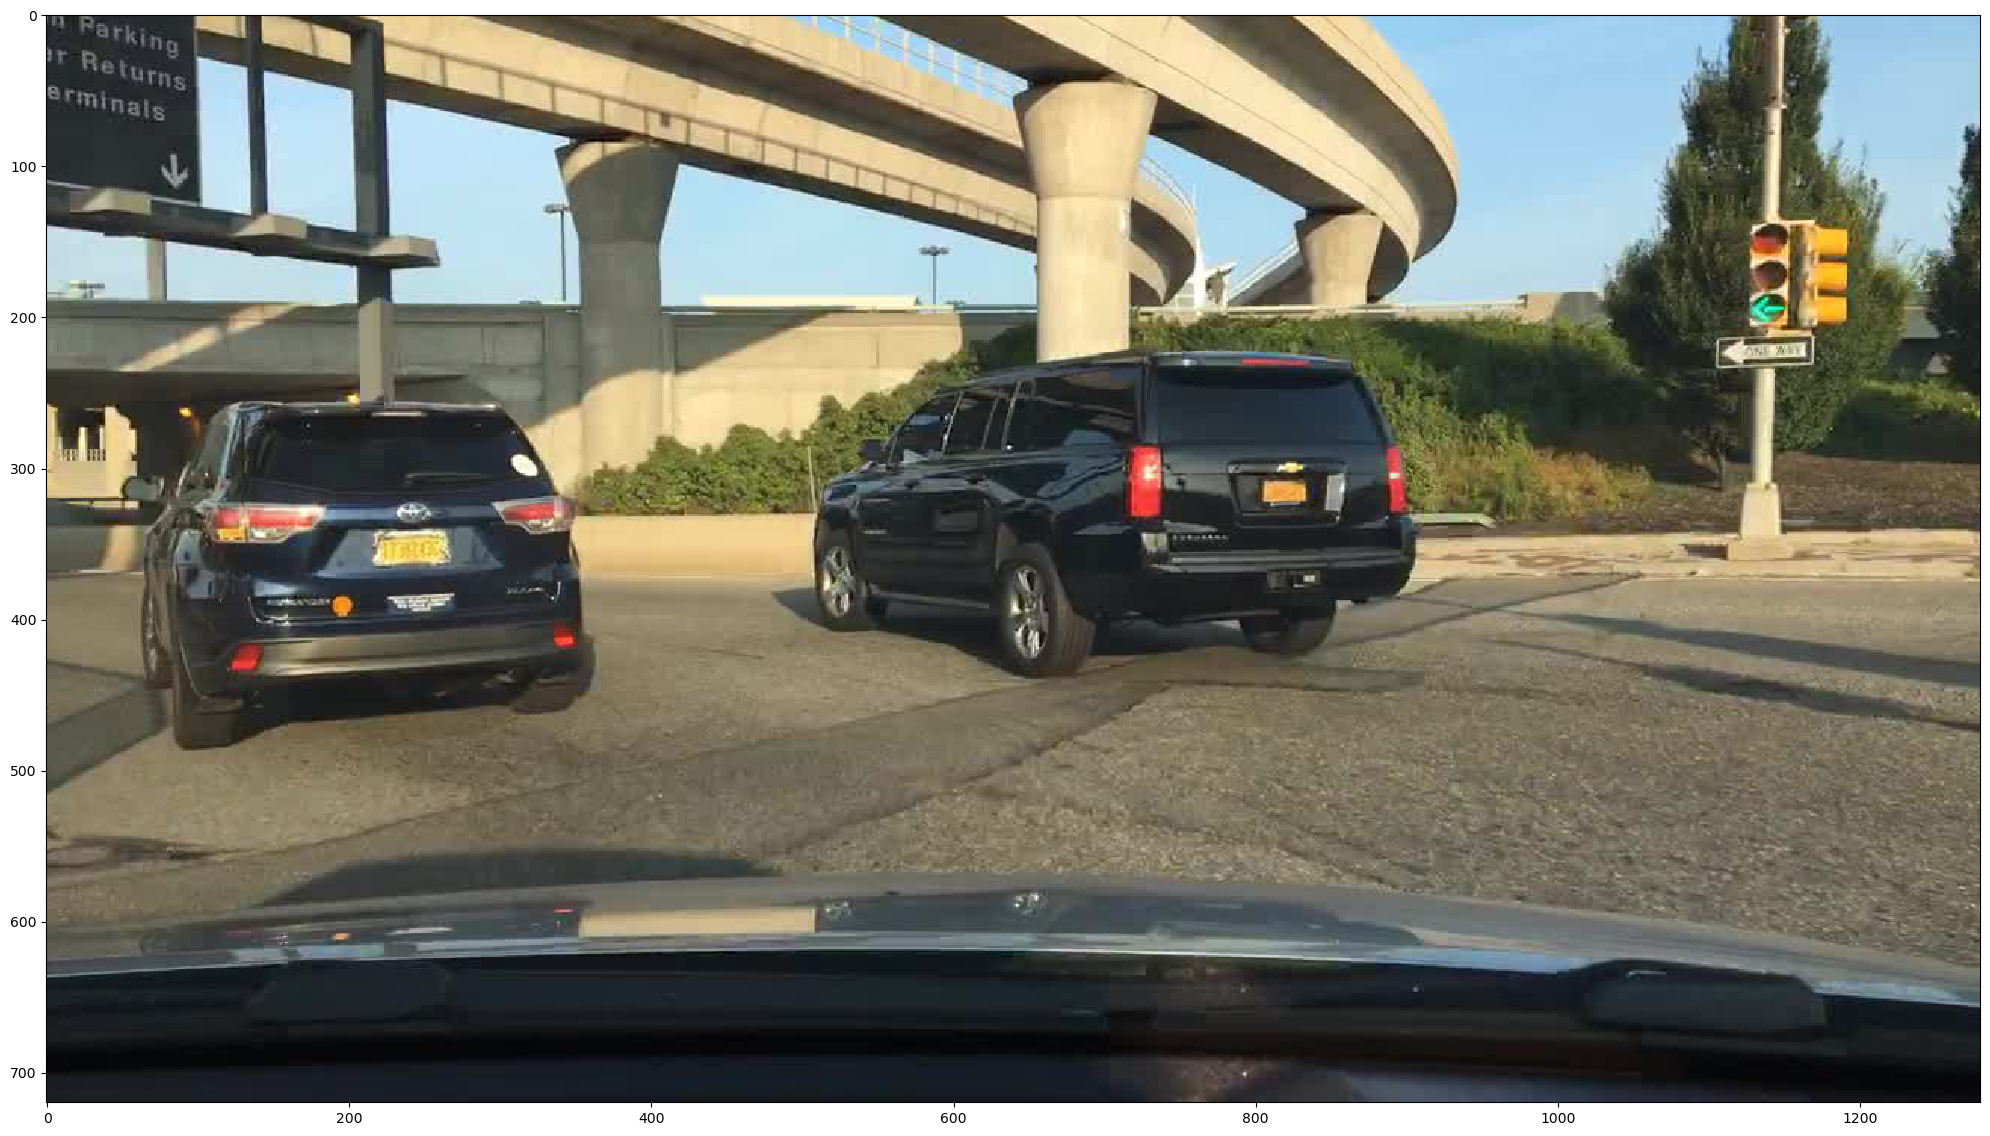

In [125]:
image = io.imread("images/0000f77c-6257be58.jpg")
io.imshow(image)

In [129]:
output_size = 416
h, w = image.shape[:2]
if isinstance(output_size, int): # the int specifies the smaller dimension, other dim scales based on it
    #if h > w:
    new_h, new_w = output_size*h/w, output_size
    #else:
    #    new_h, new_w = self.output_size, self.output_size*w/h
else: # if tuple then completely specified dims
    new_h, new_w = output_size

new_h, new_w = int(new_h), int(new_w)
resized_image = cv2.resize(image, (new_w, new_h), interpolation = cv2.INTER_CUBIC)

# make a canvas sized (output_size, output_size) filled with padding colour
canvas = np.full((output_size, output_size, 3), 128) # 128 = grey

# put image into pad canvas such that the padding now fills edges to create padded image of size (output_size, output_size)
canvas[(output_size-new_h)//2:(output_size-new_h)//2 + new_h,(output_size-new_w)//2:(output_size-new_w)//2 + new_w,  :] = resized_image

In [134]:
new_h, new_w

(234, 416)

In [133]:
canvas.shape

(416, 416, 3)

In [136]:
h,w

(720, 1280)

In [ ]:
## resize bbox labels

# h and w are swapped for labels because for images,
# x and y axes are axis 1 and 0 respectively
# broadcast (n_bboxes, 4) * (1, 4)
labels[:, :4] = labels[:, :4] * [new_w/w, new_h/h, new_w/w, new_h/h]

# add the height padding offset but only add to labels with actual detections
# filter out all non detection labels or else it will mess up the entire label array
# i.e. non detection labels wont be full vector of 0s anymore
labels[:, 1] = labels[:, 1] + ((self.output_size-new_h)//2)*(~np.all(labels==0, axis=1))

## Where are the values blowing up?

In [2]:
prediction = torch.load("ex_tensors/before_pred_trans.pt")
print(prediction.shape)

torch.Size([1, 51, 52, 52])


In [8]:
prediction = torch.load("ex_tensors/before_pred_trans.pt")
print(prediction.shape)
batch_size = prediction.shape[0]
stride = 416 // prediction.shape[2]
grid_size = prediction.shape[2]
bbox_attrs = 5 + 12
n_anchors = len(anchors)
eps = 1e-10

torch.Size([1, 51, 52, 52])


In [ ]:
prediction = prediction.view(batch_size, bbox_attrs*n_anchors, grid_size*grid_size)  # size (n_batches, (4+1+n_classes)*n_anchors, (grid_w*grid_h))
prediction = prediction.transpose(1,2).contiguous()                                  # size (n_batches, (grid_w*grid_h), (4+1+n_classes)*n_anchors)
prediction = prediction.view(batch_size, grid_size*grid_size*n_anchors, bbox_attrs)  # size (n_batches, (grid_w*grid_h*n_anchors), 4+1+n_classes)

# divide anchors by stride of detection feature map as input image is larger than detection map by a factor of stride
anchors = [(a[0]/stride, a[1]/stride) for a in anchors]

## transform output
# apply sigmoid to x,y coords and object confidence score
prediction[:,:,0] = torch.sigmoid(prediction[:,:,0]) # centre x coord - first index of each bbox attr row
prediction[:,:,1] = torch.sigmoid(prediction[:,:,1]) # centre y coord
prediction[:,:,4] = torch.sigmoid(prediction[:,:,4]) # obj confidence score

# add grid offset to centre coord predictions
grid = np.arange(grid_size)
a,b = np.meshgrid(grid,grid)

# convert to float and reshape into column vectors
x_offset = torch.FloatTensor(a).view(-1,1)      # size (grid_size*grid_size, 1)    (0, 1, ..., grid_size) * grid_size times
y_offset = torch.FloatTensor(b).view(-1,1)      # size (grid_size*grid_size, 1)    (0) * grid_size times, (1) * grid_size times, ... (grid_size) * grid_size times


x_offset = x_offset.cuda()
y_offset = y_offset.cuda()

x_y_offset = torch.cat((x_offset, y_offset), 1) # size (grid_size*grid_size, 2)
x_y_offset = x_y_offset.repeat(1, n_anchors)    # size (grid_size*grid_size, 2*n_anchors)
x_y_offset = x_y_offset.view(-1,2)              # size (grid_size*grid_size*n_anchors, 2)
x_y_offset = x_y_offset.unsqueeze(0)            # size (1, grid_size*grid_size*n_anchors, 2)

# apply x y grid offset to x y centre coords (indices 0, 1 of bbox attrs row)
prediction[:,:,:2] = prediction[:,:,:2] + x_y_offset/416

## apply anchors to dimensions of bbox
# log transform height and width

# convert to tensor
anchors = torch.FloatTensor(anchors) # size (n_anchors, 2)


anchors = anchors.cuda()

anchors = anchors.repeat(grid_size*grid_size, 1).unsqueeze(0) # size (1, grid_size*grid_size, 2)

# apply anchors to bbox width and height (indices 2, 3 of bbox attrs row)
# print("before:")
# print(f"    min:    {torch.min(prediction[:,:,2:4])}")
# print(f"    max:    {torch.max(prediction[:,:,2:4])}")
prediction[:,:,2:4] = torch.exp(prediction[:,:,2:4])*anchors + eps

In [41]:
# add grid offset to centre coord predictions
grid = np.arange(grid_size)
a,b = np.meshgrid(grid,grid)

In [42]:
# convert to float and reshape into column vectors
x_offset = torch.FloatTensor(a).view(-1,1)      # size (grid_size*grid_size, 1)    (0, 1, ..., grid_size) * grid_size times
y_offset = torch.FloatTensor(b).view(-1,1)      # size (grid_size*grid_size, 1) 

In [43]:
x_y_offset = torch.cat((x_offset, y_offset), 1)

In [44]:
x_y_offset

tensor([[ 0.,  0.],
        [ 1.,  0.],
        [ 2.,  0.],
        ...,
        [49., 51.],
        [50., 51.],
        [51., 51.]])

In [45]:
x_y_offset = x_y_offset.repeat(1, n_anchors)
x_y_offset

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  1.,  0.,  1.,  0.],
        [ 2.,  0.,  2.,  0.,  2.,  0.],
        ...,
        [49., 51., 49., 51., 49., 51.],
        [50., 51., 50., 51., 50., 51.],
        [51., 51., 51., 51., 51., 51.]])

In [46]:
x_y_offset = x_y_offset.view(-1,2)
x_y_offset

tensor([[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        ...,
        [51., 51.],
        [51., 51.],
        [51., 51.]])

In [49]:
x_y_offset[0:10]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [2., 0.],
        [2., 0.],
        [2., 0.],
        [3., 0.]])

In [50]:
anchors

array([[[116,  90],
        [156, 198],
        [373, 326]],

       [[ 30,  61],
        [ 62,  45],
        [ 59, 119]],

       [[ 10,  13],
        [ 16,  30],
        [ 33,  23]]])

In [52]:
[(a[0]/stride, a[1]/stride) for a in anchors]

[(array([14.5 , 11.25]), array([19.5 , 24.75])),
 (array([3.75 , 7.625]), array([7.75 , 5.625])),
 (array([1.25 , 1.625]), array([2.  , 3.75]))]

In [57]:
torch.FloatTensor(anchors).cuda().repeat(grid_size*grid_size, 1).unsqueeze(0)

RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

In [2]:
label = torch.load("ex_tensors/loss_label.pt")
pred = torch.load("ex_tensors/loss_pred.pt")

In [3]:
label.shape

torch.Size([16, 10647, 17])

In [4]:
label[0][label[0].nonzero()][...,0:4]

tensor([[[0.0805, 0.5380, 0.1611, 0.1837],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0805, 0.5380, 0.1611, 0.1837],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0805, 0.5380, 0.1611, 0.1837],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        ...,

        [[0.9638, 0.4602, 0.0702, 0.2715],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.9638, 0.4602, 0.0702, 0.2715],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.9638, 0.4602, 0.0702, 0.2715],
         [0.0000, 0.0000, 0.0000, 0.0000]]])

In [5]:
pred[0][pred[0].nonzero()][...,0:4]

tensor([[[6.3842e-02, 7.0782e-02, 1.0573e+02, 9.7717e+01],
         [6.3842e-02, 7.0782e-02, 1.0573e+02, 9.7717e+01]],

        [[6.3842e-02, 7.0782e-02, 1.0573e+02, 9.7717e+01],
         [7.0913e-02, 6.6256e-02, 2.4342e+02, 3.0022e+02]],

        [[6.3842e-02, 7.0782e-02, 1.0573e+02, 9.7717e+01],
         [6.3576e-02, 6.7000e-02, 1.2812e+03, 1.7774e+03]],

        ...,

        [[1.7451e-02, 1.7960e-02, 5.1602e+01, 2.6300e+01],
         [6.7991e-02, 7.7083e-02, 1.0388e+03, 2.0600e+03]],

        [[1.7451e-02, 1.7960e-02, 5.1602e+01, 2.6300e+01],
         [6.5178e-02, 7.8269e-02, 1.4465e+01, 8.5588e+00]],

        [[1.7451e-02, 1.7960e-02, 5.1602e+01, 2.6300e+01],
         [7.7979e-02, 6.9007e-02, 2.7072e+01, 3.0580e+01]]], device='cuda:0',
       grad_fn=<SliceBackward0>)

# Write Results

In [51]:
prediction = torch.load("ex_tensors/yolo_layer_output_size10647.pt")
confidence = 0.5 # filter grids without a pr(ob) > 0.5
num_classes = 80
nms_conf = 0.4

In [52]:
conf_mask = (prediction[:,:,4] > confidence).float().unsqueeze(2)
prediction = prediction*conf_mask

In [53]:
box_corner = prediction.new(prediction.shape)
box_corner[:,:,0] = (prediction[:,:,0] - prediction[:,:,2]/2)
box_corner[:,:,1] = (prediction[:,:,1] - prediction[:,:,3]/2)
box_corner[:,:,2] = (prediction[:,:,0] + prediction[:,:,2]/2) 
box_corner[:,:,3] = (prediction[:,:,1] + prediction[:,:,3]/2)
prediction[:,:,:4] = box_corner[:,:,:4]

In [55]:
for ind in range(1):
    image_pred = prediction[ind]          #image Tensor
    #confidence threshholding 
    #NMS

    max_conf, max_conf_score = torch.max(image_pred[:,5:5+ num_classes], 1)
    max_conf = max_conf.float().unsqueeze(1)
    max_conf_score = max_conf_score.float().unsqueeze(1)
    seq = (image_pred[:,:5], max_conf, max_conf_score)
    image_pred = torch.cat(seq, 1)
    
    non_zero_ind =  (torch.nonzero(image_pred[:,4]))
    try:
        image_pred_ = image_pred[non_zero_ind.squeeze(),:].view(-1,7)
    except:
        continue
    
    if image_pred_.shape[0] == 0:
        continue     

In [65]:
image_pred.shape

torch.Size([10647, 7])

In [62]:
image_pred_ = torch.cat((torch.zeros((image_pred_.shape[0], 1)), image_pred_), 1)

In [63]:
image_pred_

tensor([[  0.0000, 260.4430,  96.7705, 370.6997, 145.4609,   0.9891,   0.8380,
           7.0000],
        [  0.0000, 268.3782,  94.7033, 374.9456, 145.8965,   0.7709,   0.8236,
           7.0000],
        [  0.0000,  59.0262, 109.7473, 309.9195, 266.9929,   0.7363,   0.9938,
           1.0000],
        [  0.0000,  91.1993, 100.4477, 304.9465, 276.3017,   0.5328,   0.9873,
           1.0000],
        [  0.0000,  63.6384, 119.8179, 309.9497, 289.3002,   0.9904,   0.9980,
           1.0000],
        [  0.0000,  87.8459, 116.1371, 307.0424, 289.9205,   0.9936,   0.9993,
           1.0000],
        [  0.0000,  71.3474, 173.7214, 168.3941, 327.2916,   0.9487,   0.9987,
          16.0000],
        [  0.0000,  67.1713, 162.9582, 173.7498, 338.0852,   0.9998,   0.9992,
          16.0000],
        [  0.0000,  71.9760, 157.9328, 192.1129, 335.5837,   0.8839,   0.9954,
          16.0000],
        [  0.0000,  69.0054, 183.4312, 167.7904, 336.2758,   0.9358,   0.9983,
          16.0000],
        [ 

In [36]:
write_results(prediction_raw, confidence, num_classes, nms_conf)

tensor([[  0.0000,  87.8459, 116.1371, 307.0424, 289.9205,   0.9936,   0.9993,
           1.0000],
        [  0.0000, 260.4430,  96.7705, 370.6997, 145.4609,   0.9891,   0.8380,
           7.0000],
        [  0.0000,  67.1713, 162.9582, 173.7498, 338.0852,   0.9998,   0.9992,
          16.0000]])

# Images into Detect Loop

In [2]:
images = "images"
imlist = [osp.join(osp.realpath('.'), images, img) for img in os.listdir(images)]

In [3]:
imlist

['/home/mcav/panoptic_perception_network/images/dog-cycle-car.png',
 '/home/mcav/panoptic_perception_network/images/0001542f-7c670be8.jpg',
 '/home/mcav/panoptic_perception_network/images/0000f77c-62c2a288.jpg',
 '/home/mcav/panoptic_perception_network/images/0000f77c-6257be58.jpg',
 '/home/mcav/panoptic_perception_network/images/0001542f-5ce3cf52.jpg']

In [11]:
loaded_ims = [cv2.imread(x) for x in imlist]
for im in loaded_ims:
    print(im.shape)

(452, 602, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


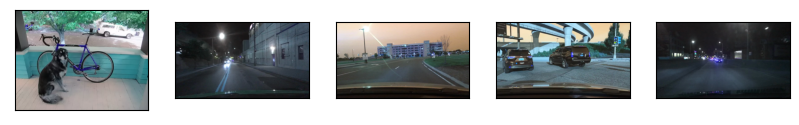

In [22]:
fig, axs = plt.subplots(1, len(loaded_ims))
for i, ax in enumerate(axs):
    ax.imshow(loaded_ims[i])

    ax.set_xticks([])
    ax.set_yticks([])

plt.gcf().set_size_inches(10,20)

In [16]:
im_batches = list(map(prep_image, loaded_ims, [inp_dim for x in range(len(imlist))]))
for im in im_batches:
    print(im.shape)

torch.Size([1, 3, 416, 416])
torch.Size([1, 3, 416, 416])
torch.Size([1, 3, 416, 416])
torch.Size([1, 3, 416, 416])
torch.Size([1, 3, 416, 416])


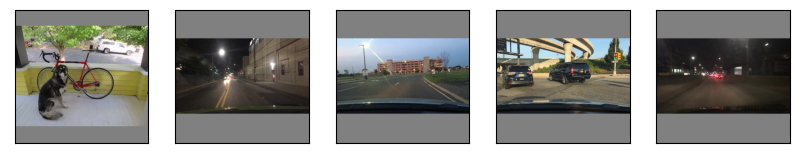

In [24]:
fig, axs = plt.subplots(1, len(im_batches))
for i, ax in enumerate(axs):
    ax.imshow(im_batches[i][0].permute(1,2,0))

    ax.set_xticks([])
    ax.set_yticks([])

plt.gcf().set_size_inches(10,20)

# Images from Dataset

In [2]:
from dataset import *
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

rgb_mean = [92, 103, 105]
rgb_std  = [66, 71, 75]
bs = 4
label_dict = "debug_dataset/labels/det_train_shortened.json" 
root_dir = "debug_dataset/images"   # labels json

### Without Norm

In [3]:
train_data = DetectionDataset(
    label_dict,
    root_dir,
    "data/bdd100k.names",
    grid_sizes=[13, 26, 52],                    # grid sizes for detection
    anchors = np.array([                        # anchor box sizes per grid size
            [[116,90], [156,198], [373,326]],   
            [[30, 61], [62, 45], [59,119]],
            [[10, 13], [16, 30], [33, 23]],
    ]),
    transform=transforms.Compose([              # transforms
        # Normalise(                              # 1. normalise
        #     mean=rgb_mean,                      
        #     std=rgb_std
        # ),
        Pad(416),                               # 2. padding
        ToTensor()                              # 3. convert to tensor
    ])
)

loader = DataLoader(
    train_data,
    batch_size=bs,
    shuffle=False,
    num_workers=8,
)

##
images_, labels_ = next(iter(loader)).values()

### With Norm

In [4]:
transformed_train_data = DetectionDataset(
    label_dict=label_dict,                      # labels corresponding to images
    root_dir=root_dir,                          # images root dir
    classes_file="data/bdd100k.names",          # class names
    grid_sizes=[13, 26, 52],                    # grid sizes for detection
    anchors = np.array([                        # anchor box sizes per grid size
            [[116,90], [156,198], [373,326]],   
            [[30, 61], [62, 45], [59,119]],
            [[10, 13], [16, 30], [33, 23]],
        ]),
    transform=transforms.Compose([              # transforms
        Normalise(                              # 1. normalise
            mean=rgb_mean,                      
            std=rgb_std
        ),
        Pad(416),                               # 2. padding
        ToTensor()                              # 3. convert to tensor
    ])
)

# separate transformed dataset into batches
train_loader = DataLoader(
    transformed_train_data,
    batch_size=bs,
    shuffle=False,
    num_workers=8,
)

##
images, labels = next(iter(train_loader)).values()

### Show Images

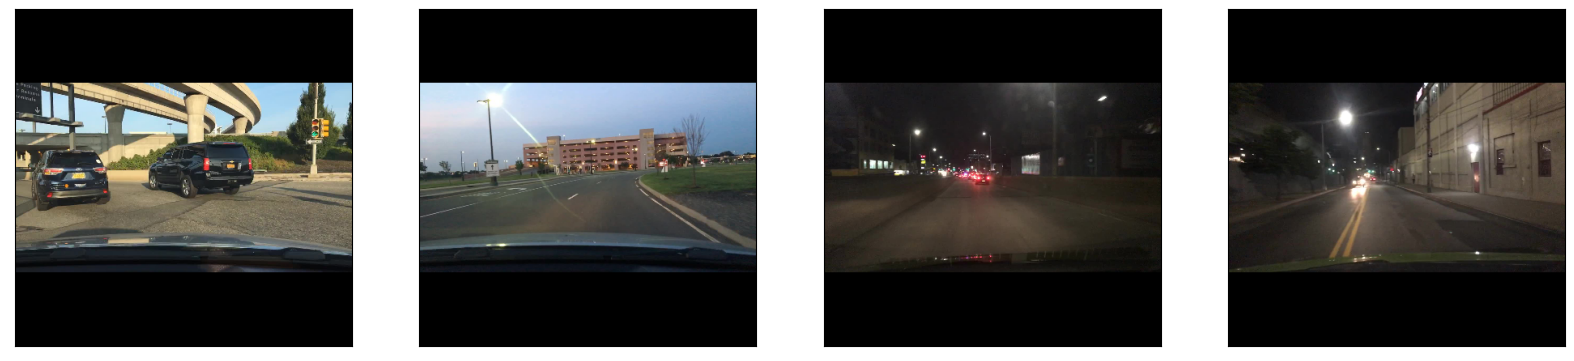

In [5]:
fig, axs = plt.subplots(1,images_.shape[0])

for i, ax in enumerate(axs):
    ax.imshow(images_[i].type(torch.int32).permute(1,2,0))
    ax.set_xticks([])
    ax.set_yticks([])

plt.gcf().set_size_inches(20,10)

In [45]:
def norm_with_padding(img: np.ndarray, in_dims: int) -> np.ndarray:
    """Adds padding to image in order to adhere to size (in_dims, in_dims, 3).

    Does not change aspect ratio.

    Args:
        img (np.ndarray): Image to be padded.
        in_dims (int): Dimension of image.

    Returns:
        canvas (np.ndarray): Padded and normalised image.
    """
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = in_dims

    # calculate new width and height
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)
    
    canvas = np.full((in_dims[1], in_dims[0], 3), 128/255)

    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
    
    return canvas

def prep_image(img, in_dims, mean, std):
    """
    Prepare image for inputting to the neural network. 
    
    Returns a Variable 
    """
    img = img.astype(float)
    # first normalise image
    img[:,:,0] = (img[:,:,0] - mean[0])/std[0]
    img[:,:,1] = (img[:,:,1] - mean[1])/std[1]
    img[:,:,2] = (img[:,:,2] - mean[2])/std[2]

    # then pad the image
    img = (norm_with_padding(img, (in_dims, in_dims)))
    # then transpose to correct dims order and tensorise 
    img = img[:,:,::-1].transpose((2,0,1)).copy()
    img = torch.from_numpy(img).float().unsqueeze(0)
    
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


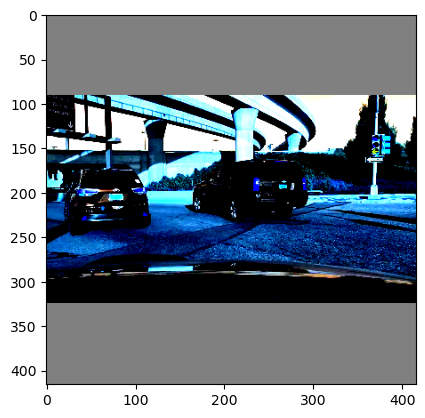

In [58]:
raw = plt.imread("images/0000f77c-6257be58.jpg")
raw_img = raw.copy().astype(float)

proc = prep_image(raw_img, 416, rgb_mean, rgb_std)
plt.imshow(proc.squeeze(0).permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


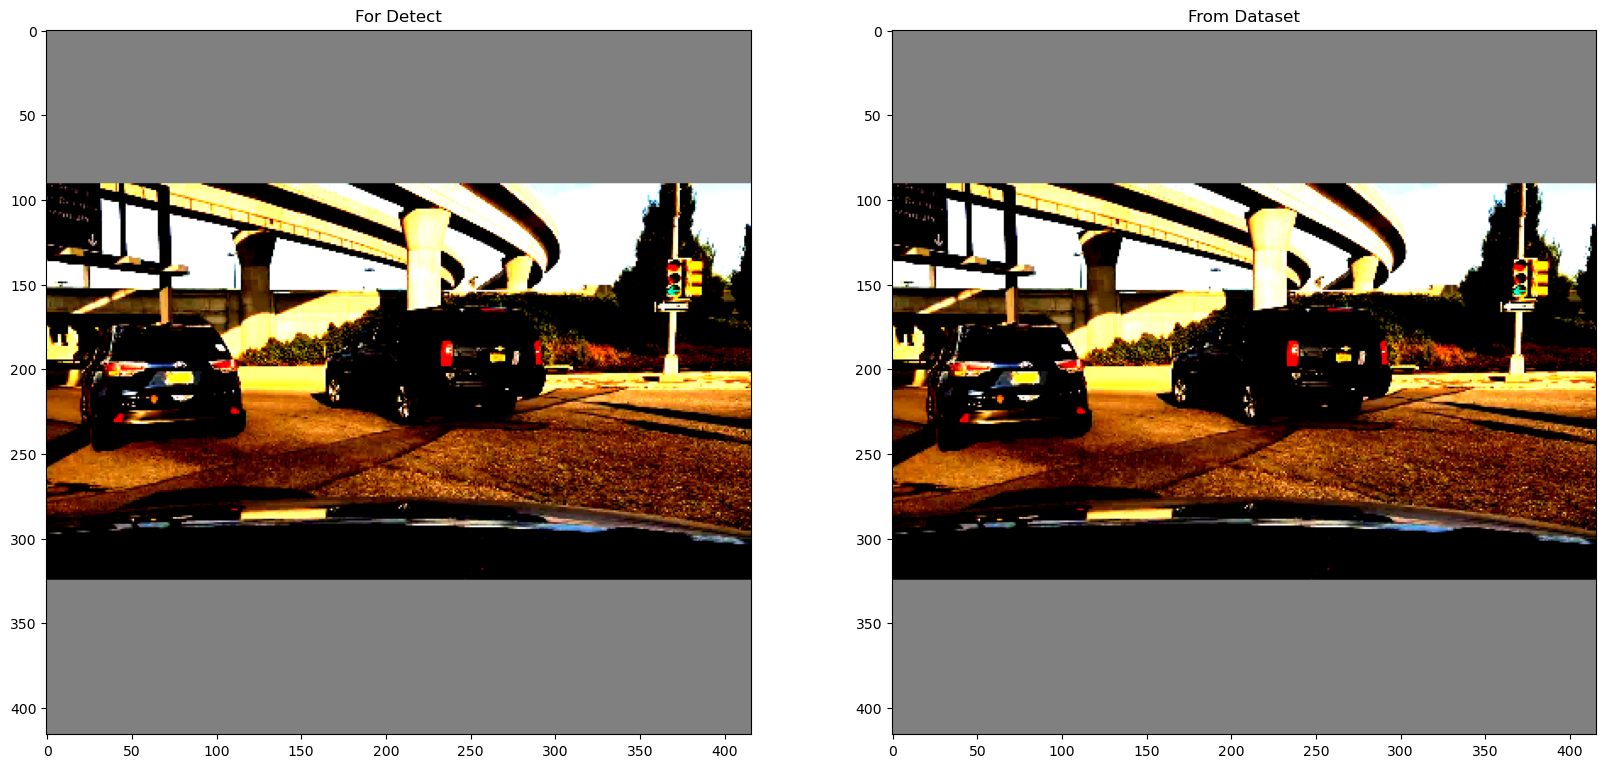

In [5]:
img_in = torch.load("ex_tensors/model_input_3") # from detect.py


fig1, (ax11,ax12) = plt.subplots(1,2)

ax11.imshow(img_in.cpu().squeeze(0).permute(1,2,0))
ax11.set_title("For Detect")

ax12.imshow(images[0].permute(1,2,0))
ax12.set_title("From Dataset")

plt.gcf().set_size_inches(20,10)
plt.show()

In [15]:
for i in range(3):
    images_[0][i] = (images_[0][i] - rgb_mean[i])/rgb_std[i]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


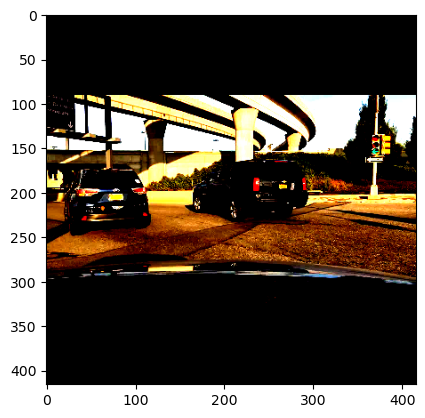

In [17]:
plt.imshow(images_[0].permute(1,2,0))

## Im 1

In [6]:
## my labels
img0, label0 = images_[0], labels_[0].unsqueeze(0).to(torch.device("cuda"))
label0.shape

torch.Size([1, 10647, 17])

In [7]:
## detections using pretrained weights
pt_dets = torch.load("og_ex_tensors/raw_pred_3.pt")
pt_dets.shape

torch.Size([1, 10647, 85])

In [8]:
## detections using my trained weights
dets = torch.load("ex_tensors/det_3.pt")
dets.shape

torch.Size([1, 10647, 17])

In [85]:
## doublecheck loss between my labels and my detections
criterion = Yolo_Loss()
loss, no_obj_loss, obj_loss, bbox_loss, class_loss, cls_acc, objs_acc, njs_acc, iou = criterion(dets, label0)
print(f"loss:\t\t {loss}")
print(f"  no_obj_loss:\t {no_obj_loss}")
print(f"  obj_loss:\t {obj_loss}")
print(f"  bbox_loss:\t {bbox_loss}")
print(f"  class_loss:\t {class_loss}")
print(f"cls_acc:\t {cls_acc}")
print(f"objs_acc:\t {objs_acc}")
print(f"njs_acc:\t {njs_acc}")
print(f"iou:\t\t {iou}")

loss:		 2.7796294689178467
  no_obj_loss:	 0.17468760907649994
  obj_loss:	 0.3937772214412689
  bbox_loss:	 0.1586759239435196
  class_loss:	 1.7191251516342163
cls_acc:	 76.47058868408203
objs_acc:	 82.35294342041016
njs_acc:	 92.10724639892578
iou:		 35.04560470581055


In [9]:
pt_dets_norm = pt_dets.clone()
pt_dets_norm[...,0:4] = pt_dets_norm[...,0:4]/416

In [10]:
criterion = Yolo_Loss()
loss, no_obj_loss, obj_loss, bbox_loss, class_loss, cls_acc, objs_acc, njs_acc, iou = criterion(pt_dets, label0)
print(f"loss:\t\t {loss}")
print(f"  no_obj_loss:\t {no_obj_loss}")
print(f"  obj_loss:\t {obj_loss}")
print(f"  bbox_loss:\t {bbox_loss}")
print(f"  class_loss:\t {class_loss}")
print(f"cls_acc:\t {cls_acc}")
print(f"objs_acc:\t {objs_acc}")
print(f"njs_acc:\t {njs_acc}")
print(f"iou:\t\t {iou}")

loss:		 468601.03125
  no_obj_loss:	 0.001795276184566319
  obj_loss:	 3.7763819694519043
  bbox_loss:	 46859.30859375
  class_loss:	 4.126007556915283
cls_acc:	 28.571430206298828
objs_acc:	 57.142860412597656
njs_acc:	 99.94361114501953
iou:		 0.0


In [27]:
# separate out each bbox attribute
bbox_dets = dets[...,0:4]
obj_dets = dets[...,4]
classes_dets = dets[...,5:]

bbox_pt_dets = pt_dets[...,0:4]
obj_pt_dets = pt_dets[...,4]
classes_pt_dets = pt_dets[...,5:]

bbox_labels = label0[...,0:4]
obj_labels = label0[...,4]
classes_labels = label0[...,5:]

In [12]:
# define losses
bce = nn.BCELoss()

In [28]:
# label where there are objects
obj_pos_labels = label0[obj_labels == 1][...,4]
obj_pos_labels

tensor([1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

In [29]:
obj_pos_pt_dets = pt_dets[obj_labels == 1][...,4]
obj_pos_pt_dets

tensor([9.9740e-01, 9.9938e-01, 4.0264e-05, 1.0824e-04, 8.4714e-01, 6.2785e-01,
        1.4317e-03], device='cuda:0')

In [30]:
bbox_centres = pt_dets[pt_dets[...,4] > 0.5][...,0:2]

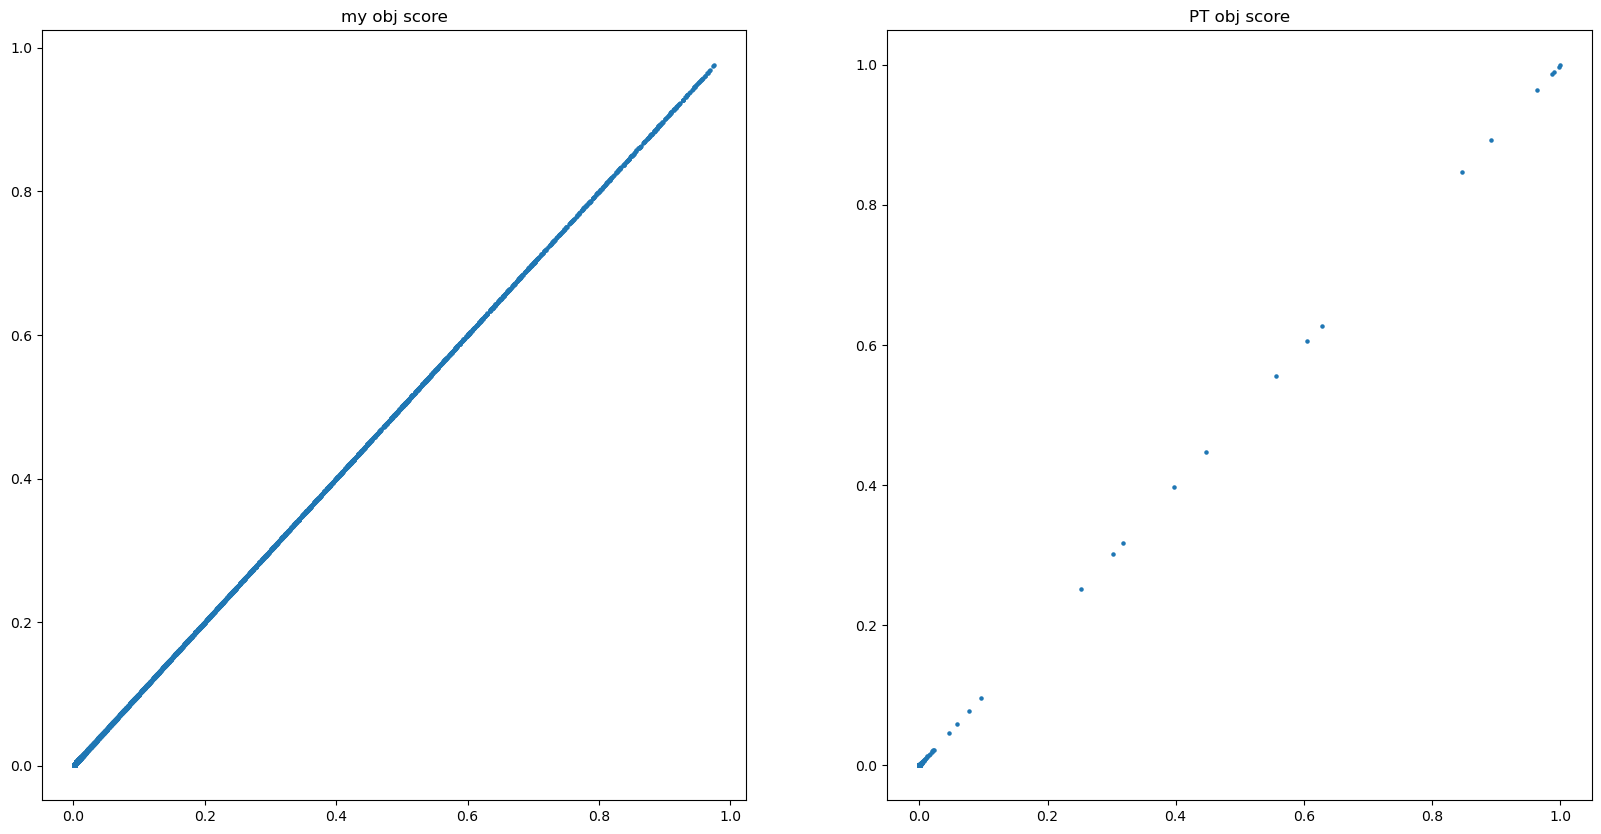

In [34]:
fig2, (ax21,ax22) = plt.subplots(1,2)

ax21.scatter(dets[...,4].cpu(), dets[...,4].cpu(), s=5)
ax21.set_title("my obj score")

ax22.scatter(pt_dets[...,4].cpu(), pt_dets[...,4].cpu(), s = 5)
ax22.set_title("PT obj score")

plt.gcf().set_size_inches(20,10)
plt.show()

In [35]:
# how many confident prediction are there using PT weights?
(pt_dets[...,4] > 0.5).sum()

tensor(10, device='cuda:0')

In [14]:
label0[...,4].nonzero(as_tuple=True)

(tensor([0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([ 240,  255,  978, 1056, 5482, 5485, 5793], device='cuda:0'))

In [19]:
label0[0][978]*416

tensor([ 16.3120, 110.9993,  32.6240,  39.8382, 416.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000, 416.0000,
          0.0000,   0.0000,   0.0000], device='cuda:0')

In [20]:
np.array([978, 1056, 5482, 5485, 5793]) - 13*13*3

array([ 471,  549, 4975, 4978, 5286])

In [63]:
# from top left corner: [right, down, width, height]

In [44]:
(pt_dets[...,4] > 0.5).nonzero(as_tuple=True)

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([ 216,  237,  240,  252,  255,  369, 5481, 5482, 5485, 5488],
        device='cuda:0'))

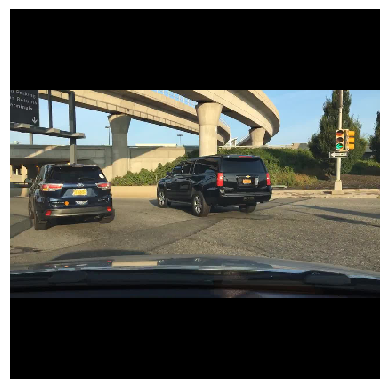

In [26]:
plt.imshow(images_[0].type(torch.int32).permute(1,2,0), interpolation='nearest')
plt.axis("off")
plt.savefig("im1.jpg", bbox_inches='tight')

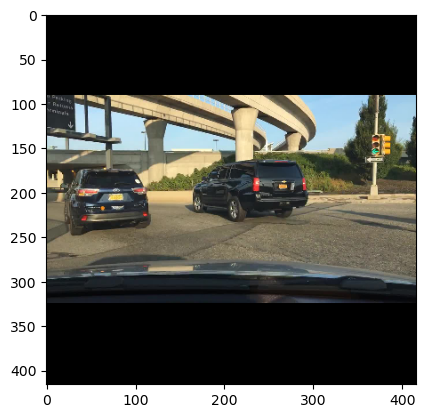

In [30]:
def save_image(data, filename):
    sizes = np.shape(data)     
    fig = plt.figure()
    fig.set_size_inches(1. * sizes[0] / sizes[1], 1, forward = False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data)
    plt.savefig(filename, dpi = sizes[0]) 
    plt.close()

# saved "padded" image
data = images_[0].type(torch.int32).permute(1,2,0)
save_image(data, 'im1.jpg')
plt.imshow(images_[0].type(torch.int32).permute(1,2,0))

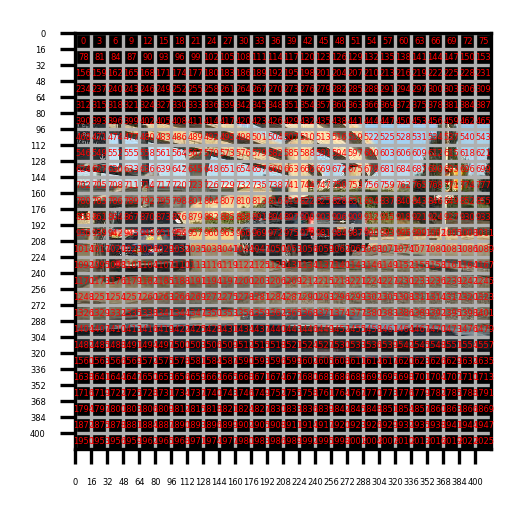

In [50]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
try:
    from PIL import Image
except ImportError:
    import Image

# Open image file
image = Image.open('im1.jpg')
# image = img_in.cpu().squeeze(0).permute(1,2,0)
my_dpi=300.

# Set up figure
fig=plt.figure(figsize=(float(image.size[0])/my_dpi,float(image.size[1])/my_dpi),dpi=my_dpi)
ax=fig.add_subplot(111)

# Remove whitespace from around the image
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

# Set the gridding interval: here we use the major tick interval
myInterval=16. # 13x13: 32, 26x26: 16, 52x52: 8
loc = plticker.MultipleLocator(base=myInterval)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)

# Add the grid
ax.grid(which='major', axis='both', linestyle='-')

# Add the image
ax.imshow(image)
ax.tick_params(axis='x', labelsize=2)
ax.tick_params(axis='y', labelsize=2)

# Find number of gridsquares in x and y direction
nx=abs(int(float(ax.get_xlim()[1]-ax.get_xlim()[0])/float(myInterval)))
ny=abs(int(float(ax.get_ylim()[1]-ax.get_ylim()[0])/float(myInterval)))

# Add some labels to the gridsquares
for j in range(ny):
    y=myInterval/2+j*myInterval
    for i in range(nx):
        x=myInterval/2.+float(i)*myInterval
        ax.text(x,y,'{:d}'.format((i+j*nx)*3),color='r',fontsize='2',ha='center',va='center')

# Save the figure
fig.savefig('im1_grid.jpg',dpi=my_dpi)

In [69]:
(pt_dets[...,4] > 0.5).nonzero(as_tuple=True)

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([ 216,  237,  240,  252,  255,  369, 5481, 5482, 5485, 5488],
        device='cuda:0'))

In [106]:
pt_dets[0][5482][0:5]

tensor([370.9966, 148.2943,  12.7371,  24.6840,   0.8471], device='cuda:0')

## Im 2

In [75]:
## my labels
img2, label2 = images_[2], labels_[2].unsqueeze(0).to(torch.device("cuda"))
label0.shape

torch.Size([1, 10647, 17])

In [73]:
## detections using pretrained weights
pt_dets = torch.load("og_ex_tensors/raw_pred_4.pt")
pt_dets.shape

torch.Size([1, 10647, 85])

In [76]:
# separate out each bbox attribute
bbox_dets = dets[...,0:4]
obj_dets = dets[...,4]
classes_dets = dets[...,5:]

bbox_pt_dets = pt_dets[...,0:4]
obj_pt_dets = pt_dets[...,4]
classes_pt_dets = pt_dets[...,5:]

bbox_labels = label2[...,0:4]
obj_labels = label2[...,4]
classes_labels = label2[...,5:]

In [78]:
(pt_dets[...,4] > 0.5).nonzero(as_tuple=True)

(tensor([0], device='cuda:0'), tensor([6663], device='cuda:0'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


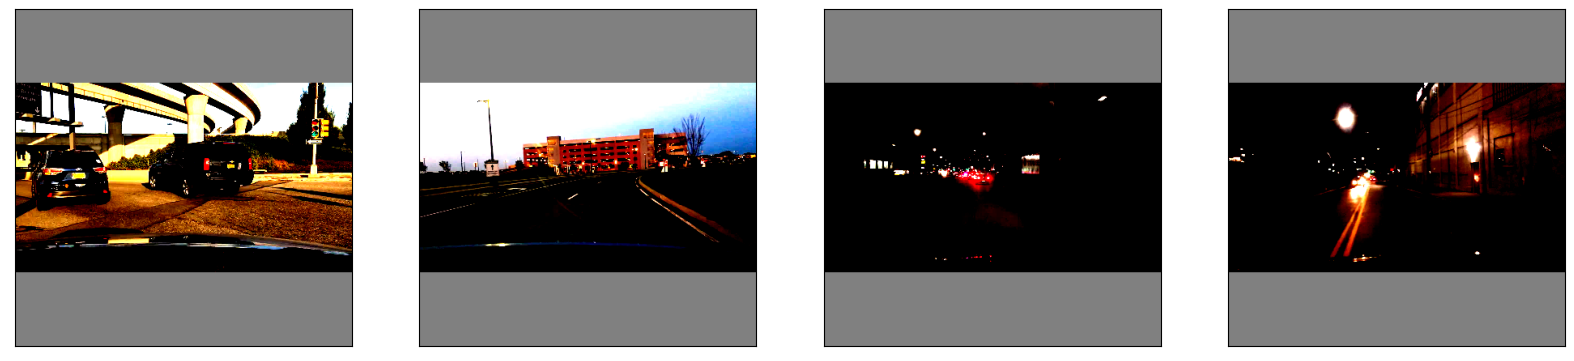

In [6]:
fig, axs = plt.subplots(1,images.shape[0])

for i, ax in enumerate(axs):
    ax.imshow(images[i].permute(1,2,0))
    ax.set_xticks([])
    ax.set_yticks([])

plt.gcf().set_size_inches(20,10)

In [21]:
def draw_labels(images, labels, anchors=None):
    if len(images.shape) == 3: # for batch size = 1
        fig, ax = plt.subplots(1, 1)
        cur_labels = labels*416
        label_bboxes = cur_labels[cur_labels.sum(dim=1) != 0][...,:4]

        # convert bbox labels to corners
        box_corner = label_bboxes.new(label_bboxes.shape)
        box_corner[...,0] = (label_bboxes[...,0] - label_bboxes[...,2]/2) # x_c - w/2 = x_min
        box_corner[...,1] = (label_bboxes[...,1] - label_bboxes[...,3]/2) # y_c - h/2 = y_min
        box_corner[...,2] = (label_bboxes[...,0] + label_bboxes[...,2]/2) # x_c + w/2 = x_max
        box_corner[...,3] = (label_bboxes[...,1] + label_bboxes[...,3]/2) # y_c + h/2 = y_max

        if images[0].max()>15: # sketchy way to check if its normalised or not
            ax.imshow(images.type(torch.int32).permute(1,2,0))
        else:
            ax.imshow(images.permute(1,2,0))
        
        for box in box_corner:
            x_points = [box[0], box[0], box[2], box[2], box[0]]
            y_points = [box[1], box[3], box[3], box[1], box[1]]
            
            ax.plot(x_points, y_points, 'r-', linewidth=0.5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Labels: {box_corner.shape[0]}  ||  Objects: {box_corner.unique(dim=0).shape[0]}")
    
    else: # for batch size > 1
        fig, axs = plt.subplots(1, images.shape[0])
        for i, ax in enumerate(axs):
            cur_labels = labels[i]*416
            label_bboxes = cur_labels[cur_labels.sum(dim=1) != 0][...,:4]
            
            # convert bbox labels to corners
            box_corner = label_bboxes.new(label_bboxes.shape)
            box_corner[...,0] = (label_bboxes[...,0] - label_bboxes[...,2]/2) # x_c - w/2 = x_min
            box_corner[...,1] = (label_bboxes[...,1] - label_bboxes[...,3]/2) # y_c - h/2 = y_min
            box_corner[...,2] = (label_bboxes[...,0] + label_bboxes[...,2]/2) # x_c + w/2 = x_max
            box_corner[...,3] = (label_bboxes[...,1] + label_bboxes[...,3]/2) # y_c + h/2 = y_max

            # convert anchor labels to corners
            #anchors = anchors.reshape(-1,2)

            if images[0].max()>15: # sketchy way to check if its normalised or not
                ax.imshow(images[i].type(torch.int32).permute(1,2,0))
            else:
                ax.imshow(images[i].permute(1,2,0))
            
            for box in box_corner:
                # show bounding boxes
                x_points = [box[0], box[0], box[2], box[2], box[0]]
                y_points = [box[1], box[3], box[3], box[1], box[1]]
                
                ax.plot(x_points, y_points, 'r-', linewidth=0.5)

                # show anchors boxes

                
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"Labels: {box_corner.shape[0]}  ||  Objects: {box_corner.unique(dim=0).shape[0]}")

    plt.gcf().set_size_inches(20,10)

In [23]:
labels[0][...,4].nonzero(as_tuple=True)

(tensor([ 240,  255,  978, 1056, 5482, 5485, 5793]),)

In [11]:
labels[0][96]*416

tensor([ 66.1782, 211.6460, 100.2173,  75.8472, 416.0000,   0.0000,   0.0000,
        416.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000])

In [14]:
im_1_bboxes = labels[0][...,4] == 1

torch.Size([10647, 17])

In [53]:
anchors.reshape(-1,2)

array([[116,  90],
       [156, 198],
       [373, 326],
       [ 30,  61],
       [ 62,  45],
       [ 59, 119],
       [ 10,  13],
       [ 16,  30],
       [ 33,  23]])

In [17]:
grid_size = 13
n_anchors = 3
grid = np.arange(grid_size)
a,b = np.meshgrid(grid,grid)
stride_x, stride_y = (416//grid_size), (416//grid_size)

# initiate empty grid cells
labels = np.zeros(shape=(grid_size, grid_size, n_anchors, 5+12))

# calculate grid cell centres
a *= stride_x 
b *= stride_y 
a = a + stride_x/2
b = b + stride_y/2

In [28]:
new_bbox = [16.6683, 112.8109,  33.2347,  43.0958]

In [29]:
grid_coords = np.concatenate((b.reshape(-1,1), a.reshape(-1,1)), axis=1)

In [36]:
dists = np.sum(np.square(grid_coords-new_bbox[:2]), axis=1).reshape(grid_size,grid_size)
w_idx, h_idx = np.unravel_index(dists.argmin(), dists.shape)

In [37]:
w_idx, h_idx

(0, 3)

In [38]:
class_array = labels[0][9][5:]

In [40]:
obj_cell_label = np.concatenate((new_bbox, np.array([1]), class_array))
# array([ 16.6683, 112.8109,  33.2347,  43.0958,   1.    ,   0.    ,
#          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
#          0.    ,   1.    ,   0.    ,   0.    ,   0.    ])

In [55]:
bbox_tile = np.tile(new_bbox[:2], [9,1])
bbox_tile

array([[ 16.6683, 112.8109],
       [ 16.6683, 112.8109],
       [ 16.6683, 112.8109],
       [ 16.6683, 112.8109],
       [ 16.6683, 112.8109],
       [ 16.6683, 112.8109],
       [ 16.6683, 112.8109],
       [ 16.6683, 112.8109],
       [ 16.6683, 112.8109]])

In [54]:
anchors.reshape(-1,2)

array([[116,  90],
       [156, 198],
       [373, 326],
       [ 30,  61],
       [ 62,  45],
       [ 59, 119],
       [ 10,  13],
       [ 16,  30],
       [ 33,  23]])

In [56]:
all_aboxes = np.concatenate((bbox_tile, anchors.reshape(-1,2)),1)
all_aboxes

array([[ 16.6683, 112.8109, 116.    ,  90.    ],
       [ 16.6683, 112.8109, 156.    , 198.    ],
       [ 16.6683, 112.8109, 373.    , 326.    ],
       [ 16.6683, 112.8109,  30.    ,  61.    ],
       [ 16.6683, 112.8109,  62.    ,  45.    ],
       [ 16.6683, 112.8109,  59.    , 119.    ],
       [ 16.6683, 112.8109,  10.    ,  13.    ],
       [ 16.6683, 112.8109,  16.    ,  30.    ],
       [ 16.6683, 112.8109,  33.    ,  23.    ]])

In [59]:
new_bbox

[16.6683, 112.8109, 33.2347, 43.0958]

In [57]:
all_aboxes = centre_dims_to_corners(all_aboxes)

In [68]:
all_aboxes.shape

(9, 4)

In [46]:
anchor_boxes = np.concatenate((bbox_tile, anchors[1]), 1)

In [47]:
anchor_boxes

array([[ 16.6683, 112.8109,  30.    ,  61.    ],
       [ 16.6683, 112.8109,  62.    ,  45.    ],
       [ 16.6683, 112.8109,  59.    , 119.    ]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


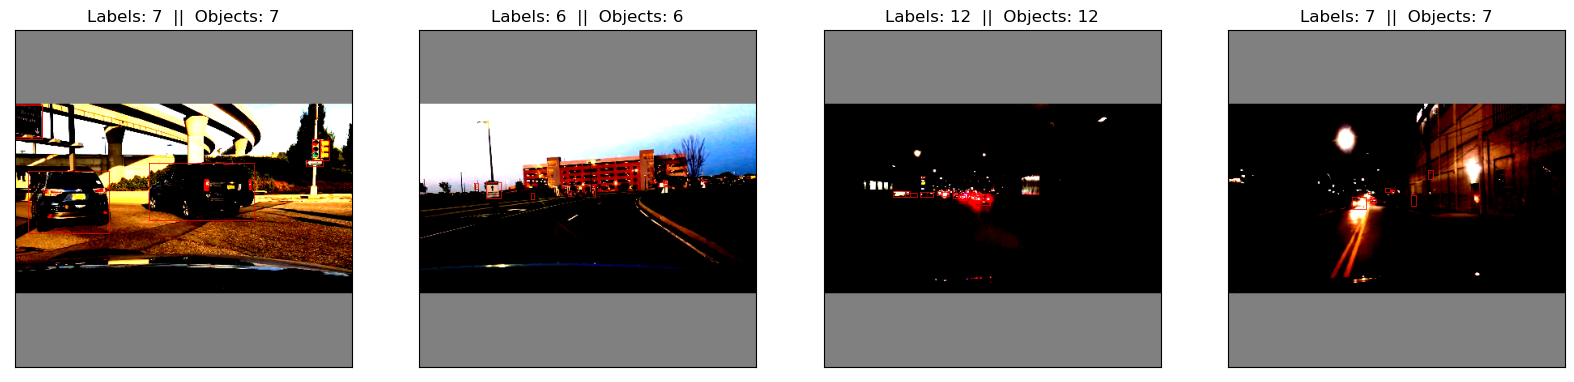

In [22]:
draw_labels(images, labels)

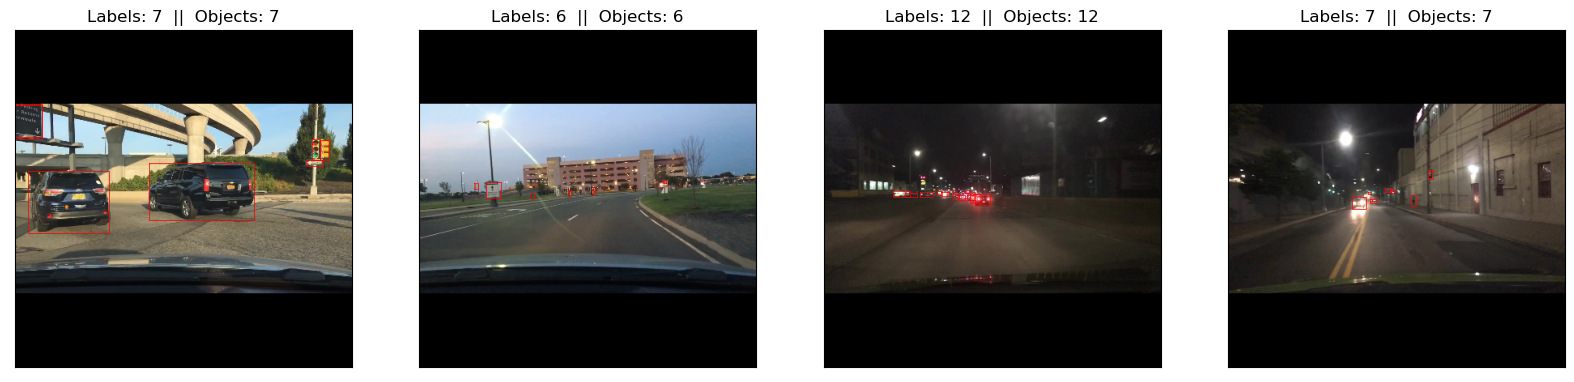

In [24]:
draw_labels(images_, labels_)

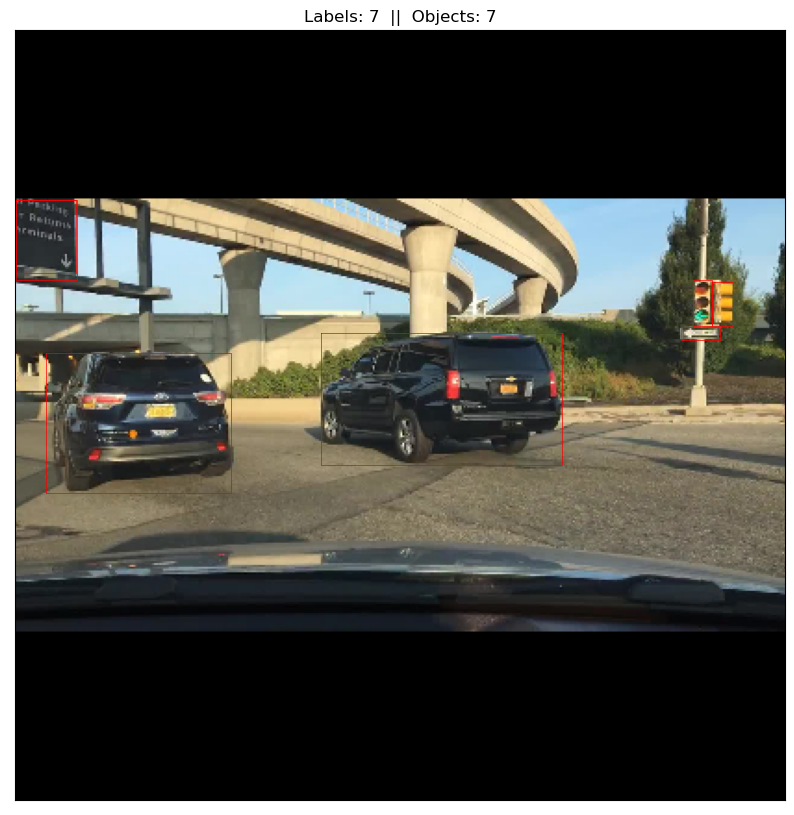

In [25]:
draw_labels(images_[0], labels_[0])

In [241]:
def distort_label(label, deltas):
    dx, dy, dw, dh = deltas

    cur_bboxes = label[...,:4]
    obj_mask = (cur_bboxes.sum(dim=1) != 0).unsqueeze(1)

    t_mat = cur_bboxes.new(cur_bboxes.shape)

    t_mat[...,0] = dx
    t_mat[...,1] = dy
    t_mat[...,2] = dw
    t_mat[...,3] = dh
    t_mat = t_mat*obj_mask

    transformed_bboxes = label[...,:4] + t_mat
    transformed_label = label.clone()
    transformed_label[...,:4] = transformed_bboxes

    return transformed_label

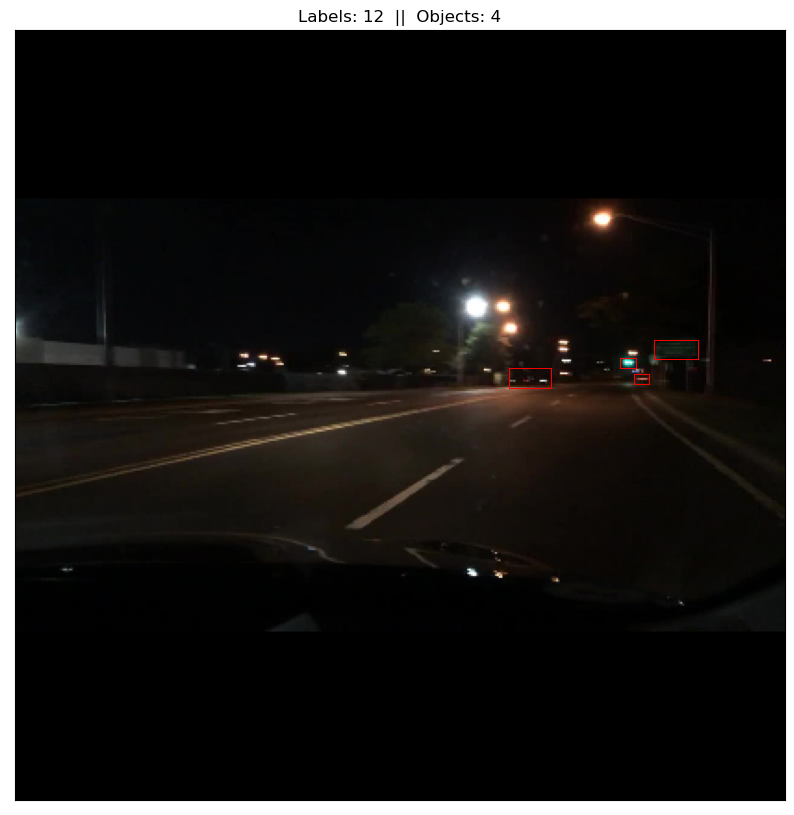

In [242]:
x_shift = distort_label(labels_[1], [0, 0, 0, 0])
draw_labels(images_[1], x_shift)

# Loss

In [16]:
criterion = Yolo_Loss()

In [244]:
dist = distort_label(labels_[1], [10, 0, 0, 0])
criterion(labels_[1], dist)

(tensor(1.6568, device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0.0381, device='cuda:0'),
 tensor(1.6187, device='cuda:0'),
 tensor(100., device='cuda:0'),
 tensor(100., device='cuda:0'),
 tensor(100., device='cuda:0'),
 tensor(40.5494, device='cuda:0'))

In [247]:
dist = distort_label(labels_[1], [0, 0, 20, 0])
criterion(labels_[1], dist)

(tensor(3.8873, device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(2.2686, device='cuda:0'),
 tensor(1.6187, device='cuda:0'),
 tensor(100., device='cuda:0'),
 tensor(100., device='cuda:0'),
 tensor(100., device='cuda:0'),
 tensor(54.1719, device='cuda:0'))